In [1]:
# GAN Used for predicting seismic data as part of Direct Diffraction Separation with Genarative Adversarial Networks
# Code by Brydon Lowney (2020)
# GAN portion of code was written with aid from machinelearningmastery.com

In [2]:
# Import modules used 
import numpy as np
import os
import datetime
import segpy as spy
import imageio
import matplotlib.pyplot as plt
import segyio
from segpy.reader import create_reader
from segpy.writer import write_segy
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
from PIL import Image
from skimage import color
from shutil import copyfile


Using TensorFlow backend.


In [3]:
# Define parameters

SEGYFILENAME  = '/home/addmin/machine_learning_dir/GAN_Git/SEISMIC/WR332a-stack.sgy' # Put in your input prediction segyfilename here
IMAGEDIR = '/home/addmin/machine_learning_dir/GAN_Git/IMAGES/' # Put your desired image directory here make sure it ends in a /
SEGYGENNAME = '/home/addmin/machine_learning_dir/GAN_Git/SEISMIC/W332a-gen.sgy' # The segy output
MODEL = '/home/addmin/machine_learning_dir/GAN_Git/MODELS/model_475000.h5' # Put desired model here (with path)

In [4]:
# Load the prediction data 

with open(SEGYFILENAME,'rb') as pre_in_file:
    
    t0 = datetime.datetime.now()
    
    pre_segy_dataset = create_reader(pre_in_file, endian='>')
    
    t1 = datetime.datetime.now()
    
    pretracefull = []
    
    for trace_index in pre_segy_dataset.trace_indexes():
        pretrace = pre_segy_dataset.trace_samples(trace_index)
        pretracetemp = []
        for n in range(0,len(pretrace)):
            temp = float(pretrace[n])
            pretracetemp.append(temp)
        pretracefull.append(pretracetemp)
    
    t2 = datetime.datetime.now()

In [5]:
# Check time to load 

time_for_header = (t1-t0).total_seconds()
time_for_traces = (t2-t1).total_seconds()
time_for_both = (t2-t0).total_seconds()

print('Time to read headers: {} seconds'.format(time_for_header))
print('Time to read traces: {} seconds'.format(time_for_traces))
print('Time to read both: {} seconds'.format(time_for_both))

Time to read headers: 0.127408 seconds
Time to read traces: 76.717897 seconds
Time to read both: 76.845305 seconds


In [6]:
# Convert the seismic to numpy array and rotate if necessary

pretracefull = np.array(pretracefull)

print(pretracefull.shape)

pretracefull = np.rot90(pretracefull, 3)

print(pretracefull.shape)

(4896, 5500)
(5500, 4896)


In [7]:
# Make the size divisible by 256 so we don't lose any data 

seismic_size = pretracefull.shape
seismic_y = seismic_size[0]
seismic_x = seismic_size[1]

mult_y = np.ceil(seismic_y/256)
mult_x = np.ceil(seismic_x/256) # ceiling is used so it always rounds up

mult_y = int(mult_y)
mult_x = int(mult_x)

new_y = mult_y*256
new_x = mult_x*256

newseismic = np.zeros((new_y,new_x))
newseismic[0:seismic_y,0:seismic_x] = pretracefull

print(seismic_size)
print(np.shape(newseismic))

(5500, 4896)
(5632, 5120)


In [8]:
# Make directories for the 256 x 256 size data for testing and save

predictdir = os.path.join(IMAGEDIR,'predict/')

if not os.path.exists(predictdir):
    os.mkdir(predictdir)

for y in range(0,(new_y-256),256):
    for x in range(0,(new_x-256),256):
        tra_256 = newseismic[y:y+256,x:x+256] 

        filenumber_y = str(y)
        filenumber_x = str(x)

        plt.imsave('{}predict_y{}_x{}.png'.format(predictdir, filenumber_y.zfill(5), filenumber_x.zfill(5)), tra_256, vmin=-5, vmax=5, cmap='Greys')


In [9]:
# Reload seismic but as an image 

pre_filelist = []

for y in range(0,(new_y-256),256):
    for x in range(0,(new_x-256),256):
        
        filenumber_y = str(y)
        filenumber_x = str(x)

        pre_filelist.append('{}predict_y{}_x{}.png'.format(predictdir, filenumber_y.zfill(5), filenumber_x.zfill(5)))
        
pre_images = np.array([np.array(Image.open(fname)) for fname in pre_filelist])

pre_images = pre_images[:,:,:,0:3]

np.shape(pre_images)

pre_images = (pre_images - 127.5) / 127.5


In [10]:
# load model

model = load_model(MODEL)

# generate image from source

gen_images = model.predict(pre_images)

/home/addmin/machine_learning_dir/neural_networks_env/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


1.0


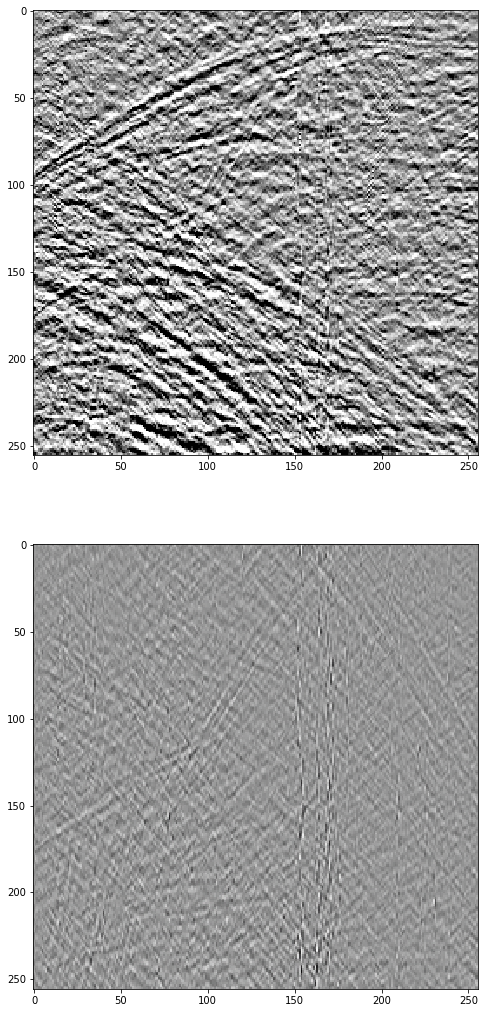

In [11]:
# Recalculate amplitudes so it fits on an RGB scale (0:1)

gen_img_plot = (gen_images + 1) / 2
pre_img_plot = (pre_images + 1) / 2 

print(np.max(pre_images))

fig, axes = pyplot.subplots(2, 1, figsize=(18, 18))
axes[0].imshow(pre_img_plot[210], cmap='Greys')
axes[1].imshow(gen_img_plot[210], cmap='Greys')

In [12]:
# Save the generated images

i = 0

gendir = os.path.join(IMAGEDIR,'generated/')

if not os.path.exists(gendir):
    os.mkdir(gendir)

for y in range(0,(new_y-256),256):
    for x in range(0,(new_x-256),256):
        
        filenumber_y = str(y)
        filenumber_x = str(x)
               
        pyplot.imsave('{}generated_y{}_x{}.png'.format(gendir,filenumber_y.zfill(5), filenumber_x.zfill(5)), gen_img_plot[i], vmin=-500, vmax=500, cmap='Greys')
        
        i = i+1        

In [19]:
# Reconstruct the generated images by first loading them and centring around zero

gen_image = np.zeros((new_y, new_x, 4))

for y in range(0,(new_y-256),256):
    for x in range(0,(new_x-256),256):
        
        filenumber_y = str(y)
        filenumber_x = str(x)

        gen_image_load = np.array(Image.open('{}generated_y{}_x{}.png'.format(gendir, filenumber_y.zfill(5), filenumber_x.zfill(5))))
        
        gen_image[y:y+256, x:x+256, :] = gen_image_load

gen_image = (gen_image - 127.5) / 127.5
gen_image = gen_image[0:seismic_y,0:seismic_x]
gen_img_plot = (gen_image + 1) / 2

np.shape(gen_image)

(5500, 4896, 4)

In [14]:
# Save the full image into the gen directory

plt.imsave('{}/full_generated_image.png'.format(gendir), gen_img_plot, cmap='Greys')

In [36]:
# Convert to amplitude (centred around 0) and save to segy

gen_seis = color.rgb2gray(color.rgba2rgb(gen_image))

gen_seis = np.rot90(gen_seis)

#datasets = [gen_seis]

# Save the new data

input_file = SEGYFILENAME
output_file = SEGYGENNAME

with segyio.open(input_file, ignore_geometry=True) as src:
    spec = segyio.spec()
    spec.sorting = src.sorting
    spec.format = src.format
    spec.samples = src.samples
    spec.ilines = src.ilines
    spec.xlines = src.xlines
    spec.tracecount = seismic_x
    with segyio.create(output_file, spec) as dst:
        dst.text[0] = src.text[0]
        dst.bin = src.bin
        dst.header = src.header
        dst.trace = gen_seis